This notebook shows some examples of fitting different models to classification/regression datasets. We start by loading some classifiers / regressors from `imodels`.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn import metrics

# installable with: `pip install imodels`
import imodels
from imodels import SLIMClassifier, OneRClassifier, BoostedRulesClassifier, FIGSClassifier, HSTreeClassifierCV
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor, GreedyRuleListClassifier
from imodels.discretization import ExtraBasicDiscretizer
import demo_helper
np.random.seed(13)

Let's start by loading some data in...

In [2]:
# ames housing dataset: https://www.openml.org/search?type=data&status=active&id=43926
X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = demo_helper.get_ames_data()


# diabetes dataset: https://www.openml.org/search?type=data&sort=runs&id=37&status=active
X_train, X_test, y_train, y_test, feat_names = demo_helper.get_diabetes_data()
    # feat_names meanings:
    # ["#Pregnant", "Glucose concentration test", "Blood pressure(mmHg)",
    # "Triceps skin fold thickness(mm)",
    # "2-Hour serum insulin (mu U/ml)", "Body mass index", "Diabetes pedigree function", "Age (years)"]

# load some data
print('Regression data training', X_train_reg.shape, 'Classification data training', X_train.shape)

regression data (365, 33) classification data (192, 8)


We will now show how to fit different models. All models support the `fit` and `predict` method (classifiers also support `predict_proba`).

The simplest way to visualize a fitted model `m` is usually just to call `str(m)` or `print(m)`. Some models have custom methods that allow you to visualize them further...To pass feature names into a model for visualization, you can usually (i) pass in the `feature_names` argument to the `fit` function or (ii) pass in a pandas dataframe with the feature names as column names.

Let's overview 4 types of models: (1) Rule sets, (2) Rule trees, (3) Rule lists, and (4) Algebraic models.

<div>
<img src="https://csinva.io/imodels/img/model_table.png" width="500"/>
</div>

# 1. Rule sets
Rule sets are models that create a set of (potentially overlapping) rules.

### Rulefit

In [11]:
# fit a rulefit model
rulefit = RuleFitRegressor(max_rules=10)
rulefit.fit(X_train_reg, y_train_reg, feature_names=feat_names_reg)

# get test performance
preds = rulefit.predict(X_test_reg)
print(f'Test R2: {metrics.r2_score(y_test_reg, preds):0.2f}')
print(rulefit)

# inspect and print the rules
print('Rulefit has an alternative visualization:')
rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
    # 'rule' is how the feature is constructed
    # 'coef' is its weight in the final linear model
    # 'support' is the fraction of points it applies to
rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis')

Test R2: 0.66
> ------------------------------
> RuleFit:
> 	Predictions are made by summing the coefficients of each rule
> ------------------------------
                                         rule      coef
                                  OverallQual  18030.26
                                  TotalBsmtSF      3.45
                                    GrLivArea     25.83
                                   GarageArea     20.86
GrLivArea <= 1934.0 and TotalBsmtSF <= 1430.5 -14394.51
GrLivArea <= 1903.0 and TotalBsmtSF <= 1332.5 -12041.07
   1stFlrSF <= 1417.0 and YearBuilt <= 1994.5  -2717.86
   1stFlrSF <= 1417.0 and YearBuilt <= 1983.5  -4041.35

Rulefit has an alternative visualization:


,rule,coef,support
2,OverallQual,18030.256330,1.000000
9,TotalBsmtSF,3.450805,1.000000
13,GrLivArea,25.833881,1.000000
23,GarageArea,20.858433,1.000000
36,GrLivArea <= 1934.0 and TotalBsmtSF <= 1430.5,-14394.507762,0.695890
35,GrLivArea <= 1903.0 and TotalBsmtSF <= 1332.5,-12041.069850,0.635616
34,1stFlrSF <= 1417.0 and YearBuilt <= 1994.5,-2717.861406,0.526027
33,1stFlrSF <= 1417.0 and YearBuilt <= 1983.5,-4041.352428,0.479452


## Boosted stumps

> ------------------------------
> BoostedRules:
> 	Rule → predicted probability (final prediction is weighted sum of all predictions)
> ------------------------------
  If Glucose concentration test <= 99.5 → 0.00 (weight: 0.33)
  If Glucose concentration test > 99.5 → 0.69 (weight: 0.39)
  If Glucose concentration test <= 99.5 → 0.27 (weight: 0.38)
  If Glucose concentration test > 99.5 → 0.60 (weight: 0.31)
  If #Pregnant <= 6.5 → 0.57 (weight: 0.27)
  If #Pregnant > 6.5 → 0.17 (weight: 0.37)
  If Body mass index <= 30.25 → 0.88 (weight: 0.07)
  If Body mass index > 30.25 → 0.00 (weight: 0.08)
  If Diabetes pedigree function <= 0.325 → 0.94 (weight: 0.11)
  If Diabetes pedigree function > 0.325 → 0.00 (weight: 0.10)



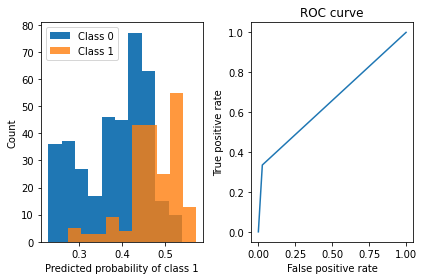

In [9]:
# fit boosted stumps
brc = BoostedRulesClassifier(n_estimators=10)
brc.fit(X_train, y_train, feature_names=feat_names)

print(brc)

# look at performance
probs = brc.predict_proba(X_test)
demo_helper.viz_classification_preds(probs, y_test)

# 2. Rule trees

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
Glucose concentration test <= 99.500 (Tree #0 root)
	Val: 0.068 (leaf)
	Glucose concentration test <= 168.500 (split)
		#Pregnant <= 6.500 (split)
			Body mass index <= 30.850 (split)
				Val: 0.065 (leaf)
				Blood pressure(mmHg) <= 67.000 (split)
					Val: 0.705 (leaf)
					Val: 0.303 (leaf)
			Val: 0.639 (leaf)
		Blood pressure(mmHg) <= 93.000 (split)
			Val: 0.860 (leaf)
			Val: -0.009 (leaf)

	+
Diabetes pedigree function <= 0.404 (Tree #1 root)
	Val: -0.088 (leaf)
	Val: 0.106 (leaf)

Alternative visualization:


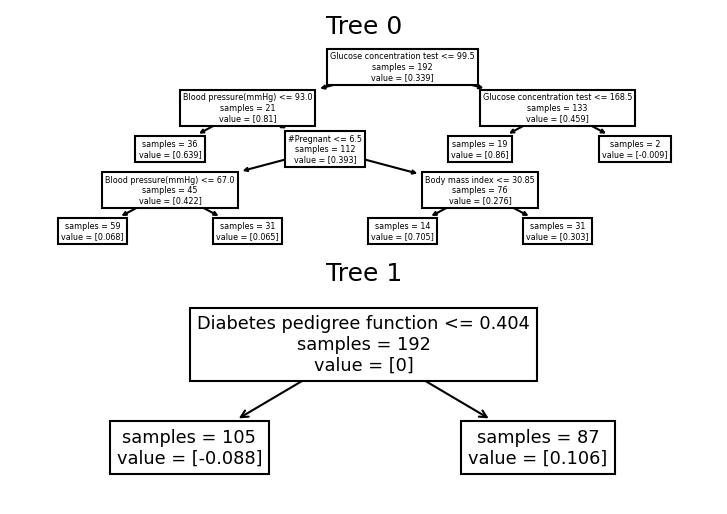

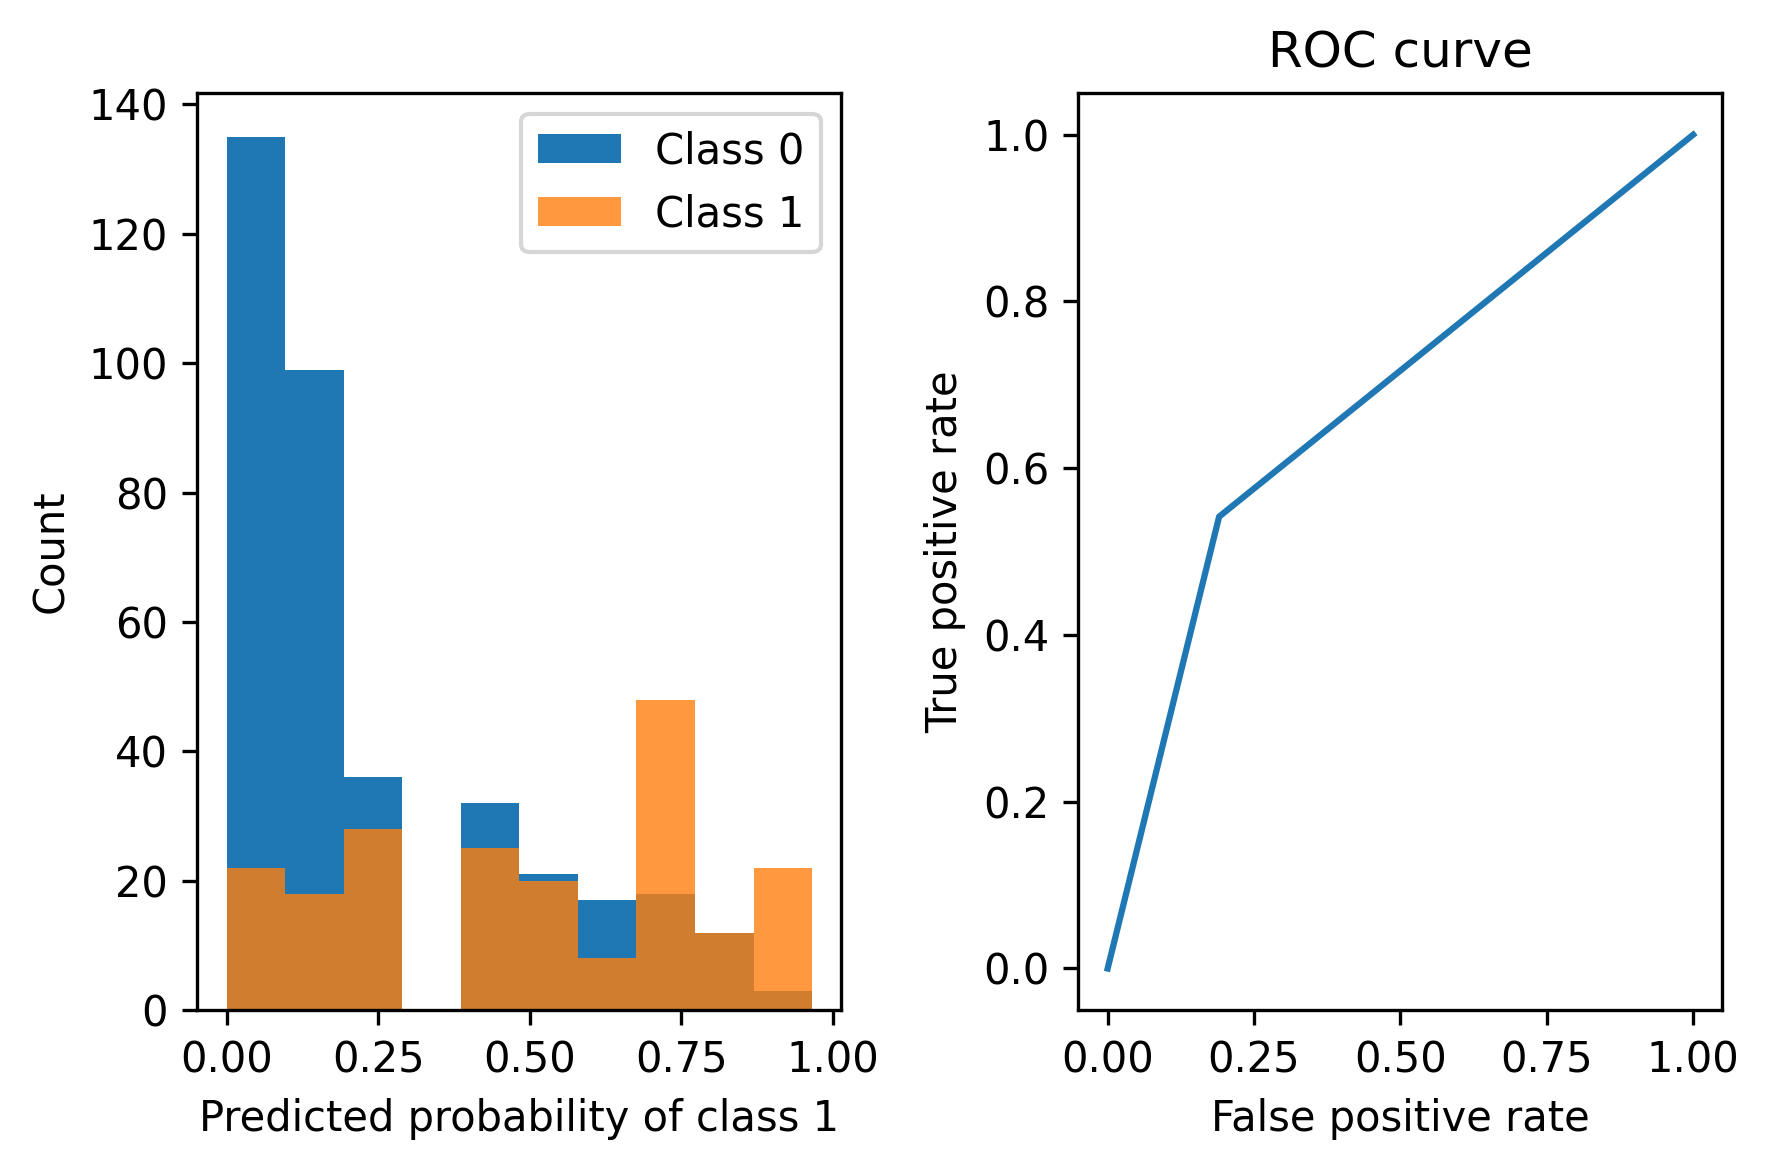

In [31]:
# specify a decision tree with a maximum depth
figs = FIGSClassifier(max_rules=7)
figs.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = figs.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')
print(figs)

print('Alternative visualization:')
figs.plot()

demo_helper.viz_classification_preds(probs, y_test)

> ------------------------------
> Decision Tree with Hierarchical Shrinkage
> 	Prediction is made by looking at the value in the appropriate leaf of the tree
> ------------------------------
|--- Glucose concentration test <= 99.50
|   |--- weights: [0.84, 0.16] class: 0
|--- Glucose concentration test >  99.50
|   |--- Glucose concentration test <= 168.50
|   |   |--- #Pregnant <= 6.50
|   |   |   |--- Body mass index <= 30.85
|   |   |   |   |--- weights: [0.77, 0.23] class: 0
|   |   |   |--- Body mass index >  30.85
|   |   |   |   |--- Blood pressure(mmHg) <= 67.00
|   |   |   |   |   |--- weights: [0.53, 0.47] class: 0
|   |   |   |   |--- Blood pressure(mmHg) >  67.00
|   |   |   |   |   |--- weights: [0.66, 0.34] class: 0
|   |   |--- #Pregnant >  6.50
|   |   |   |--- Diabetes pedigree function <= 0.26
|   |   |   |   |--- weights: [0.57, 0.43] class: 0
|   |   |   |--- Diabetes pedigree function >  0.26
|   |   |   |   |--- weights: [0.45, 0.55] class: 1
|   |--- Glucose con

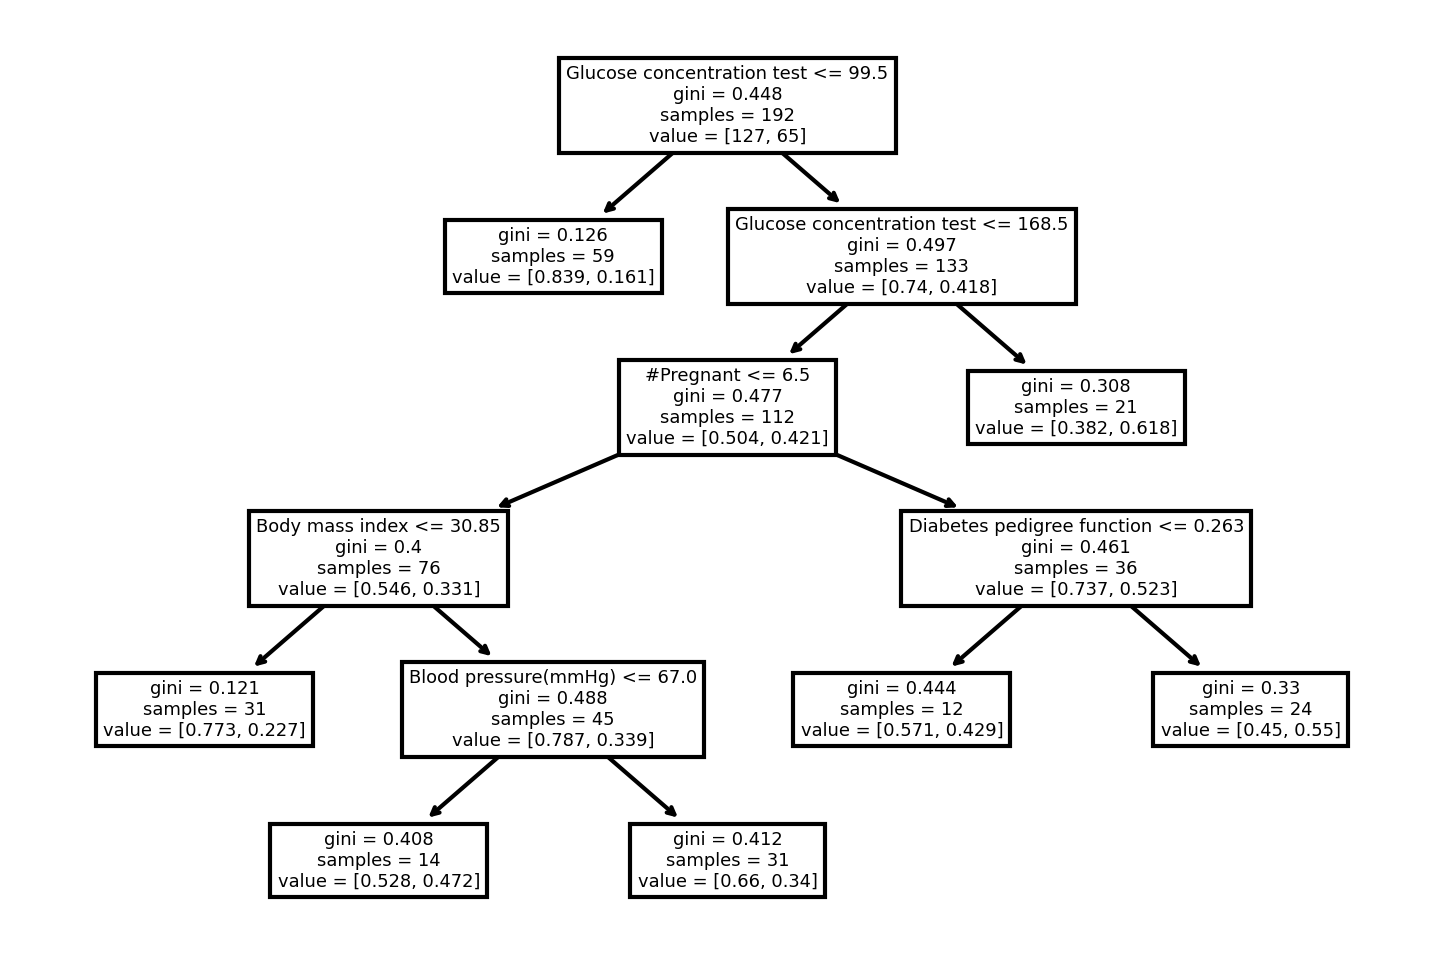

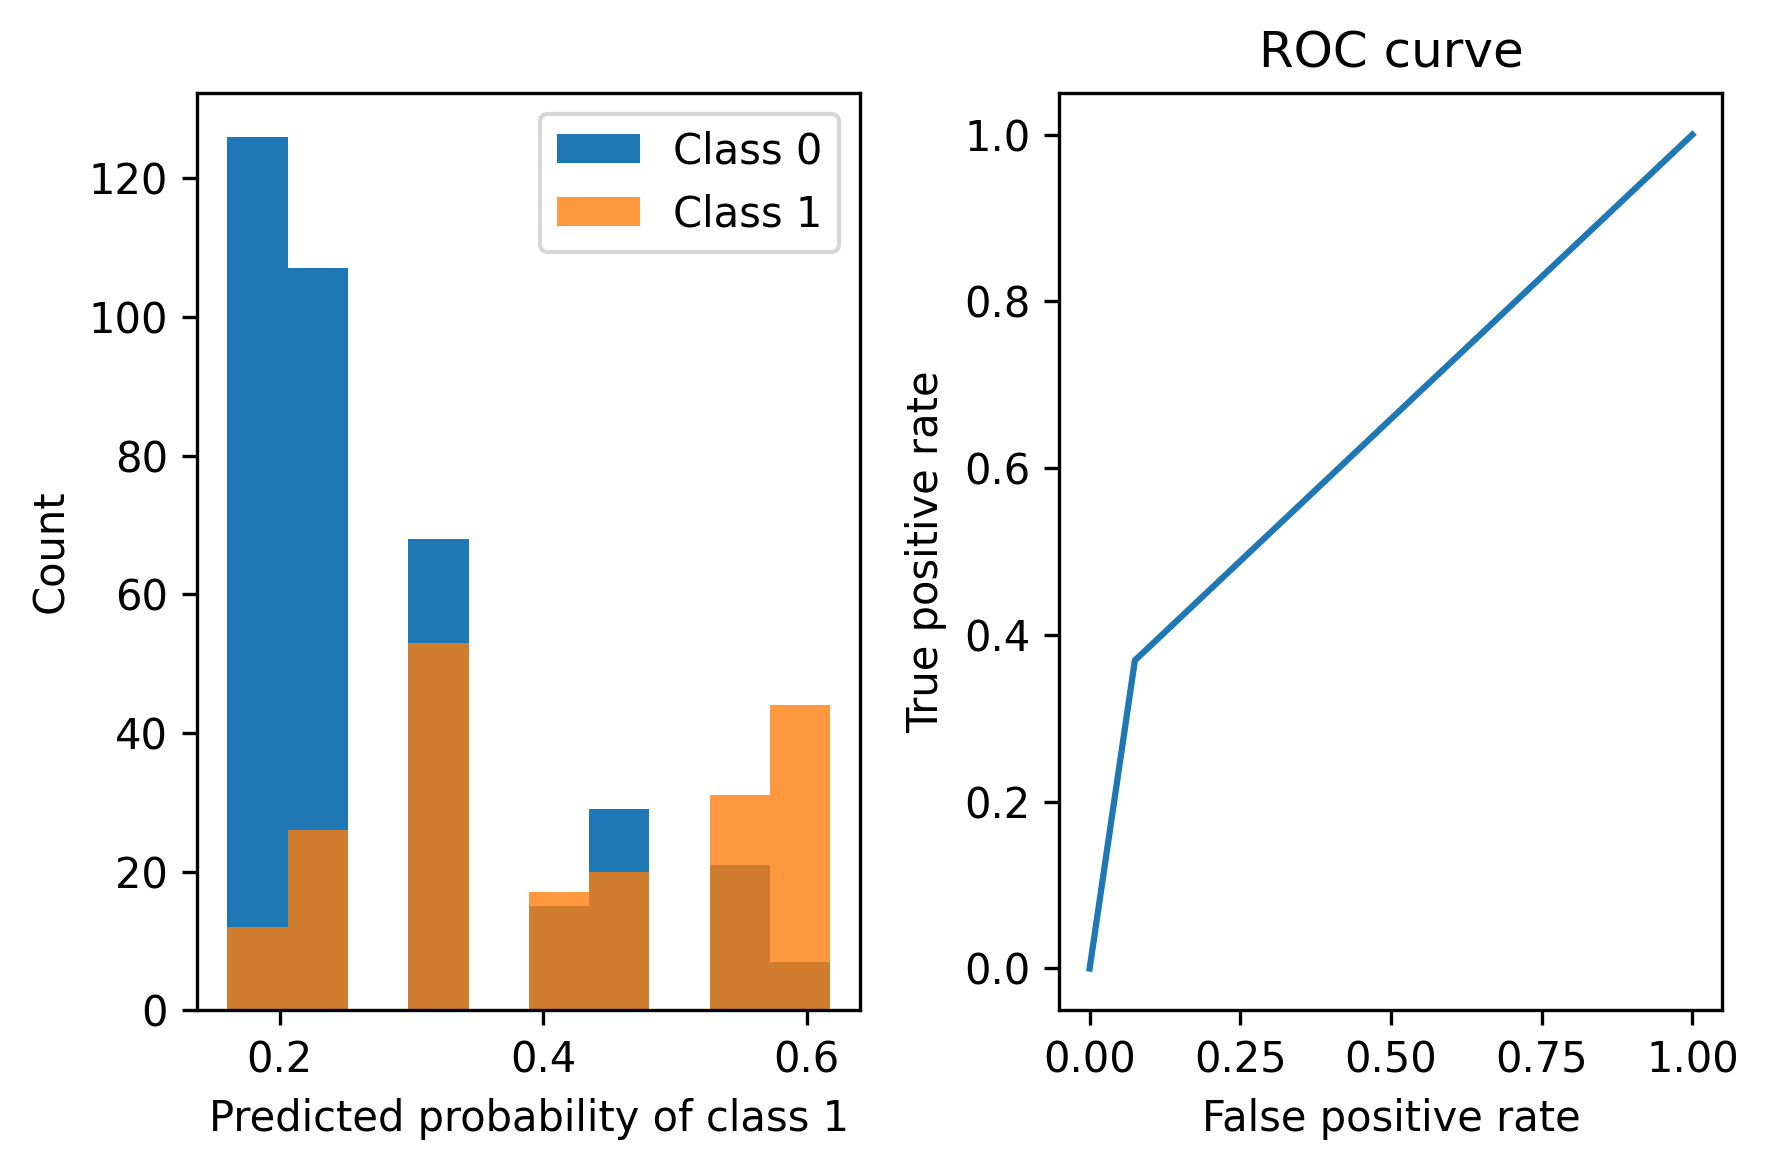

In [32]:
# specify a decision tree with a maximum depth
dt = HSTreeClassifierCV(max_leaf_nodes=7)
dt.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = dt.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')
print(dt)

print('Alternative visualization:')
plot_tree(dt.estimator_, feature_names=feat_names)
# plt.savefig('tree.pdf')
plt.show()

demo_helper.viz_classification_preds(probs, y_test)

### short decision tree

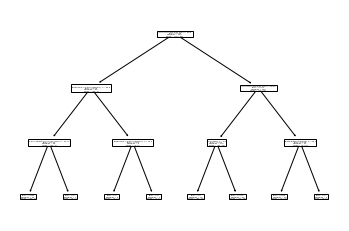

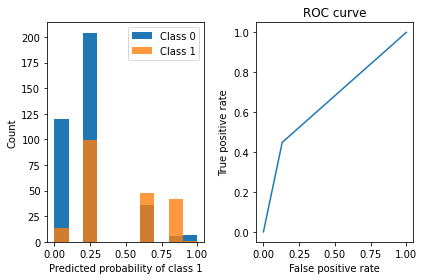

In [21]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

# calculate mse on the training data
probs = dt.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')

plot_tree(dt, feature_names=feat_names)
# plt.savefig('tree.pdf')
plt.show()

demo_helper.viz_classification_preds(probs, y_test)

### optimal classification tree
- docs [here](https://github.com/csinva/interpretability-workshop/tree/master/imodels/optimal_classification_tree)
- note: this implementation is still somewhat unstable, and can be made faster by installing either `cplex` or `gurobi`

In [ ]:
# sys.path.append('../imodels/optimal_classification_tree/pyoptree')
# sys.path.append('../imodels/optimal_classification_tree/')

In [ ]:
# from optree import OptimalTreeModel
# feature_names = np.array(["x1", "x2"])

# X = np.array([[1, 2, 2, 2, 3], [1, 2, 1, 0, 1]]).T
# y = np.array([1, 1, 0, 0, 0]).reshape(-1, 1)
# X_test = np.array([[1, 1, 2, 2, 2, 3, 3], [1, 2, 2, 1, 0, 1, 0]]).T
# y_test = np.array([1, 1, 1, 0, 0, 0, 0])

# np.random.seed(13)
# model = OptimalTreeModel(tree_depth=3, N_min=1, alpha=0.1) #, solver_name='baron'
# model.fit(X_test, y_test) # this method is currently using the fast, but not optimal solver
# preds = model.predict(X_test)

# # fit on the bigger diabetes dset from above
# # model.fit(Xtrain, ytrain) # this method is currently using the fast, but not optimal solver
# # preds = model.predict(Xtest)

# print('acc', np.mean(preds == y_test))

In [ ]:
# model.print_tree(feature_names)

# 3. Rule lists

### Greedy rule lists
**like a decision tree that only ever splits going left**

mean 0.339 (192 pts)
if Glucose concentration test >= 100.0 then 0.459 (133 pts)
mean 0.068 (59 pts)
if Triceps skin fold thickness(mm) >= 42.0 then 0.667 (3 pts)
mean 0.036 (56 pts)
if 2-Hour serum insulin (mu U/ml) >= 258.0 then 1.0 (1 pts)
mean 0.018 (55 pts)
if Diabetes pedigree function >= 0.16699999570846558 then 0.25 (4 pts)
mean 0 (51 pts)



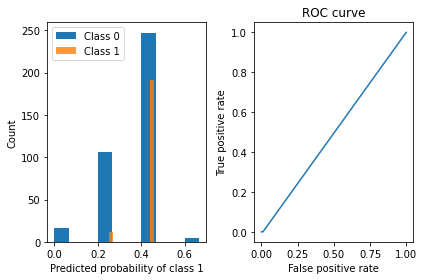

In [23]:
# fit a greedy rule list
m = GreedyRuleListClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = m.predict_proba(X_test)

# print the list
print(m)

# look at prediction breakdown
demo_helper.viz_classification_preds(probs, y_test)

### oneR
**fits a rule list restricted to use only one feature**

mean 0.339 (192 pts)
if #Pregnant >= 7.0 then 0.608 (51 pts)
mean 0.241 (141 pts)
if #Pregnant >= 3.0 then 0.305 (59 pts)
mean 0.195 (82 pts)
if #Pregnant >= 1.0 then 0.267 (30 pts)
mean 0.154 (52 pts)
if #Pregnant >= 2.0 then 0.2 (20 pts)
mean 0.125 (32 pts)
if #Pregnant >= 1.0 then 0.125 (32 pts)



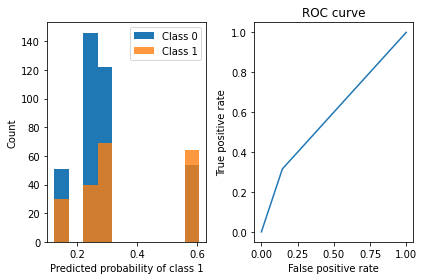

In [26]:
# fit a oneR model
m = OneRClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = m.predict_proba(X_test)

# print the rule list
print(m)

# look at prediction breakdown
demo_helper.viz_classification_preds(probs, y_test)

### Scalable bayesian rule lists

In [27]:
disc = ExtraBasicDiscretizer(feat_names[:3], n_bins=3, strategy='uniform')
X_train_brl_df = disc.fit_transform(pd.DataFrame(X_train[:, :3], columns=feat_names[:3]))
X_test_brl_df = disc.transform(pd.DataFrame(X_test[:, :3], columns=feat_names[:3]))

In [28]:
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
m = BayesianRuleListClassifier()
m.fit(X_train_brl_df.values, y_train, feature_names=X_train_brl_df.columns)

probs = m.predict_proba(X_test_brl_df.values)
print("learned model:\n", m)
demo_helper.viz_classification_preds(probs, y_test)

training...


/Users/chandan/denvs/imodels/lib/python3.8/site-packages/mlxtend-0.20.0-py3.8.egg/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


learned model:
 Trained RuleListClassifier 
IF Glucose concentration test_147.33333333333331_to_199.0 > 0.5 THEN probability of class 1: 65.9% (50.9%-79.4%)
ELSE IF Glucose concentration test_44.0_to_95.66666666666666 > 0.5 THEN probability of class 1: 11.1% (3.8%-21.7%)
ELSE IF #Pregnant_0.0_to_4.666666666666667 > 0.5 THEN probability of class 1: 22.9% (13.9%-33.3%)
ELSE probability of class 1: 47.7% (33.3%-62.3%)



/Users/chandan/denvs/imodels/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


NameError: name 'viz_classification_preds' is not defined

# Algebraic models

### Integer linear models

In [ ]:
np.random.seed(123)

# generate X and y
n, p = 500, 10
X_sim = np.random.randn(n, p)
y_sim = 1 * X_sim[:, 0] + 2 * X_sim[:, 1] - 1 * X_sim[:, 2] + np.random.randn(n)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMRegressor()
for lambda_reg in [1e-3, 1e-2, 5e-2, 1e-1, 1, 2, 5, 10]:
    model.fit(X_sim, y_sim, lambda_reg)
    mse = np.mean(np.square(y_sim - model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmse: {mse: 0.2f}\tweights: {model.model_.coef_}')

In [ ]:
y_sim = 1 / (1 + np.exp(-y_sim))
y_sim = np.round(y_sim)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMClassifier()
for lambda_reg in [1e-3, 1e-2, 5e-2, 1e-1, 1, 2, 5, 10]:
    model.fit(X_sim, y_sim, lambda_reg)
    mll = np.mean(metrics.log_loss(y_sim, model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmlogloss: {mll: 0.2f}\tweights: {model.model_.coef_}')